# Investigating effective information in artificial neural networks

$$ EI = H(\langle W_i^\text{out} \rangle) - \langle H(W_i^\text{out}) \rangle $$

In [1]:
import os
from pathlib import Path
from itertools import islice
import gzip
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

In [2]:
def H(x, dim=0):
    """Compute the Shannon information entropy of x.
    
    Given a tensor x, compute the shannon entropy along one of its axes. If
    x.shape == (N,) then returns a scalar (0-d tensor). If x.shape == (N, N)
    then information can be computed along vertical or horizontal axes by
    passing arguments dim=0 and dim=1, respectively.
    
    Note that the function does not check that the axis along which
    information will be computed represents a valid probability distribution.
    
    Args:
        x (torch.tensor) containing probability distribution
        dim (int) dimension along which to compute entropy
    
    Returns:
        (torch.tensor) of a lower order than input x
    """
    r = x * torch.log2(x)
    r[r != r] = 0
    return -torch.sum(r, dim=dim)


def soft_norm(W):
    """Turns 2x2 matrix W into a transition probability matrix.
    
    The weight/adjacency matrix of an ANN does not on its own allow for EI
    to be computed. This is because the out weights of a given neuron are not
    a probability distribution (they do not necessarily sum to 1). We therefore
    must normalize them. 
    
    Applies a softmax function to each row of matrix
    W to ensure that the out-weights are normalized.
    
    Args:
        W (torch.tensor) of shape (2, 2)
        
    Returns:
        (torch.tensor) of shape (2, 2)
    """
    return F.softmax(W, dim=1)


def lin_norm(W):
    """Turns 2x2 matrix W into a transition probability matrix.
    
    Applies a relu across the rows (to get rid of negative values), and normalize
    the rows based on their arithmetic mean.
    
    Args:
        W (torch.tensor) of shape (2, 2)
        
    Returns:
        (torch.tensor) of shape (2, 2)
    """
    W = F.relu(W)
    row_sums = torch.sum(W, dim=1)
    row_sums[row_sums == 0] = 1
    row_sums = row_sums.reshape((-1, 1))
    return W / row_sums


def sig_norm(W):
    """Turns 2x2 matrix W into a transition probability matrix.
    
    Applies logistic function on each element and normalize
    across rows.
    
    Args:
        W (torch.tensor) of shape (2, 2)
        
    Returns:
        (torch.tensor) of shape (2, 2)
    """
    W = torch.sigmoid(W)
    row_sums = torch.sum(W, dim=1).reshape((-1, 1))
    return W / row_sums


def determinism(model, norm=None):
    H_sum = 0
    N = 0
    for layer in model.children():
        if type(layer) is not nn.Linear:
            raise Exception("Can only process fully-connected layers")
        W = layer.weight.t()
        if norm:
            W = norm(W)
        H_sum += torch.sum(H(W, dim=1)).item()
        N += W.shape[0]
    return H_sum / N


def degeneracy(model, norm=None):
    in_weights = torch.zeros((0,))
    total_weight = 0
    for layer in model.children():
        if type(layer) is not nn.Linear:
            raise Exception("Can only process fully-connected layers")
        W = layer.weight.t()
        if norm:
            W = norm(W)
        in_weights = torch.cat((in_weights, torch.sum(W, dim=0)))
        total_weight += torch.sum(W).item()
    return H(in_weights / total_weight)
     


def EI(model, norm=None):
    """Compute effective information from of fully-connected sequential `model`."""
    return degeneracy(model, norm=norm) - determinism(model, norm=norm)
        

# def determinism(W, norm=None):
#     if norm:
#         W = norm(W)
#     return torch.mean(H(W, dim=1))


# def degeneracy(W, norm=None):
#     if norm:
#         W = norm(W)
#     total_weight = torch.sum(W)
#     return H(torch.sum(W, dim=0) / total_weight)


# def EI(W, norm=None):
#     """Compute effective information from connectivity matrix W."""
#     if norm:
#         W = norm(W)
#     return degeneracy(W) - determinism(W)

In [3]:
dir_path = Path().absolute()
dataset_path = dir_path.parent / "data/mnist.pkl.gz"
if not dataset_path.exists():
    print('Downloading dataset with curl ...')
    if not dataset_path.parent.exists():
        os.mkdir(dataset_path.parent)
    url = 'http://ericjmichaud.com/downloads/mnist.pkl.gz'
    os.system('curl -L {} -o {}'.format(url, dataset_path))
print('Download failed') if not dataset_path.exists() else print('Dataset acquired')
f = gzip.open(dataset_path, 'rb')
mnist = pickle.load(f)
f.close()
print('Loaded data to variable `mnist`')

Dataset acquired
Loaded data to variable `mnist`


In [4]:
dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
torch.set_default_dtype(dtype)

In [5]:
class MNISTDataset(Dataset):
    """MNIST Digits Dataset."""
    def __init__(self, data, transform=None):
        self.mnist = data
        self.transform = transform
        
    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        sample = self.mnist[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToTensor(object):
    """Convert samples (np.ndarray, np.ndarray) to (torch.tensor, torch.tensor)"""
    def __call__(self, sample):
        image, one_hot_label = sample
        image = torch.from_numpy(image).to(dtype)
        label = torch.tensor(np.argmax(one_hot_label)).to(torch.long)
        return (image, label)


In [41]:
training = MNISTDataset(mnist[:10000], transform=ToTensor())
test = MNISTDataset(mnist[60000:], transform=ToTensor())
training_loader = torch.utils.data.DataLoader(training, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=5, shuffle=True)

In [47]:
class SoftmaxRegression(nn.Module):
    """Single-layer softmax network."""
    def __init__(self, n_in, n_out):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(n_in, n_out, bias=False)
    
    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=1)
    
    
class FullyConnected(nn.Module):
    """Single-hidden-layer dense neural network."""
    def __init__(self, n_in, width, n_out):
        super(FullyConnected, self).__init__()
        self.fc1 = nn.Linear(n_in, width, bias=False)
        self.fc2 = nn.Linear(width, n_out, bias=False)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [54]:
model = SoftmaxRegression(28*28, 10)
# model = FullyConnected(28*28, 50, 10)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [55]:
results = []
num_batches = 0
ac = 0
for epoch in range(30):
    for sample, target in training_loader:
        optimizer.zero_grad()
        loss = loss_fn(model(sample), target)
        loss.backward()
        optimizer.step()
        num_batches += 1
        if num_batches % 200 == 0:
            with torch.no_grad():
                ei = EI(model, norm=lin_norm)
            results.append((num_batches, ac, ei))
    correct = 0
    outof = 0
    with torch.no_grad():
        for x, labels in islice(test_loader, 0, 200): # 200 batches of 5 samples
            output = model(x)
            _, pred = torch.max(output, 1)
            correct += (pred == labels).sum().item()
            outof += len(labels)
            ei = EI(model, norm=lin_norm)
    ac = correct / outof
    results.append((num_batches, ac, ei))
    print("Epoch {} | Accuracy = {:.4f}".format(epoch, ac))

Epoch 0 | Accuracy = 0.9020
Epoch 1 | Accuracy = 0.8980
Epoch 2 | Accuracy = 0.9140
Epoch 3 | Accuracy = 0.8970
Epoch 4 | Accuracy = 0.9110
Epoch 5 | Accuracy = 0.9090
Epoch 6 | Accuracy = 0.9160
Epoch 7 | Accuracy = 0.9100
Epoch 8 | Accuracy = 0.9190
Epoch 9 | Accuracy = 0.9230
Epoch 10 | Accuracy = 0.9030
Epoch 11 | Accuracy = 0.9240
Epoch 12 | Accuracy = 0.9140
Epoch 13 | Accuracy = 0.8950
Epoch 14 | Accuracy = 0.9030
Epoch 15 | Accuracy = 0.9200
Epoch 16 | Accuracy = 0.9000
Epoch 17 | Accuracy = 0.9090
Epoch 18 | Accuracy = 0.9170
Epoch 19 | Accuracy = 0.9240
Epoch 20 | Accuracy = 0.9220
Epoch 21 | Accuracy = 0.8920
Epoch 22 | Accuracy = 0.9170
Epoch 23 | Accuracy = 0.9160
Epoch 24 | Accuracy = 0.9100
Epoch 25 | Accuracy = 0.9220
Epoch 26 | Accuracy = 0.9150
Epoch 27 | Accuracy = 0.9070
Epoch 28 | Accuracy = 0.9180
Epoch 29 | Accuracy = 0.8990


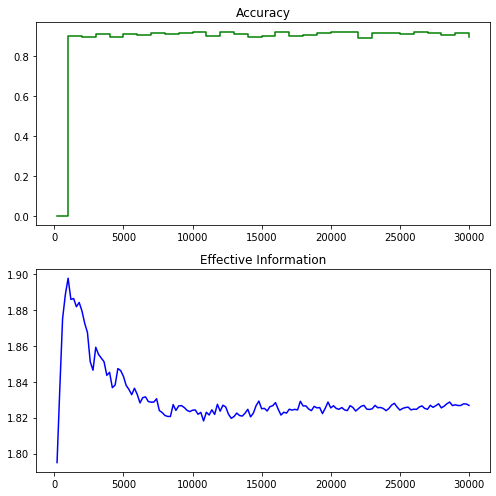

In [56]:
plt.figure(figsize=(7, 7))

x, ac, ei = zip(*results)

plt.subplot(2, 1, 1)
plt.plot(x, ac, label='Accuracy', color='green')
plt.title("Accuracy")
plt.subplot(2, 1, 2)
plt.plot(x, ei, label='EI', color='blue')
plt.title("Effective Information")

# ax1.set_xlabel('num_batches')
# ax1.plot(x, ac, label='accuracy', color='blue')
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.plot(x, ei, label='ei', color='red')

plt.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
with torch.no_grad():
    for i in range(10):
        weights = model.linear.weight[i].reshape(28,28)
        plt.subplot(2, 5, i+1)
        plt.imshow(weights.detach().numpy(), cmap='plasma')
        plt.title(str(i))

In [24]:
torch.cat?

Docstring:
cat(tensors, dim=0, out=None) -> Tensor

Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
All tensors must either have the same shape (except in the concatenating
dimension) or be empty.

:func:`torch.cat` can be seen as an inverse operation for :func:`torch.split`
and :func:`torch.chunk`.

:func:`torch.cat` can be best understood via examples.

Args:
    tensors (sequence of Tensors): any python sequence of tensors of the same type.
        Non-empty tensors provided must have the same shape, except in the
        cat dimension.
    dim (int, optional): the dimension over which the tensors are concatenated
    out (Tensor, optional): the output tensor

Example::

    >>> x = torch.randn(2, 3)
    >>> x
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497]])
    >>> torch.cat((x, x, x), 0)
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497],
            [ 0.6580, -1.0969, -0.4614],
        

In [ ]:
torch.zeros((10,)).cat

In [ ]:


torch.zeros(5)

In [ ]:
N = 100
EI(torch.normal(mean=torch.zeros((N, N)), std=1), norm=lin_norm)

In [ ]:
N = 100
EI(torch.rand((N,N)))

In [ ]:
N = 100
m = torch.zeros((N, N))
for i in range(N):
    m[i][(i-1)%N] = 1
    m[i][(i+1)%N] = 1

In [ ]:
EI(m, norm=lin_norm).item()